In [ ]:
!pip install scikit-learn

In [ ]:
#importing the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
import time
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.metrics import mean_squared_error

In [ ]:
def read_data():
  data = pd.DataFrame({
    'Temperature': [40, 60, 80, 80, 60, 40, 60, 40, 60, 60, 60, 60, 60, 60, 60, 80, 40, 60, 60, 40, 80, 60, 60, 60, 80, 80, 60, 60, 40],
    'Catalyst': [3, 3, 1, 5, 5, 5, 3, 3, 3, 1, 5, 3, 3, 3, 1, 3, 3, 3, 1, 5, 3, 1, 3, 1, 3, 3, 5, 3, 1],
    'Time': [105, 105, 105, 105, 150, 105, 105, 150, 150, 105, 105, 150, 60, 105, 105, 60, 60, 60, 60, 105, 105, 60, 105, 150, 150, 105, 60, 105, 105],
    'MethanolRatio': [15, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 15, 6, 15, 6, 15, 10.5, 15, 10.5, 10.5, 10.5, 10.5, 6, 6, 6, 6, 10.5, 10.5, 15, 10.5, 10.5, 10.5],
    'ActualYield': [59.8, 92.6, 88.2, 60.6, 85.2, 59.4, 92.6, 58.8, 75.6, 69.6, 76.6, 78.2, 84.0, 95.0, 87.0, 90.2, 81.8, 58.4, 89.6, 65.6, 59.0, 86.0, 70.0, 96.4, 74.6, 86.6, 79.0, 92.6, 79.8]
  })

  return data

In [ ]:
def preprocess_data(data, split_ratio, scaler):
  X = data.drop('ActualYield', axis=1)
  y = data['ActualYield']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=42)

  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  return X, y, X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test

In [ ]:
data = read_data()
scaler = StandardScaler()
split_ratio = 0.2
X, y, X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(data, split_ratio, scaler)

In [ ]:
def hyper_param_fit(model: str=None, param_grid: dict=None, scoring: str=None, cv: int=None):
  grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv)

  grid_search.fit(X_train_scaled, y_train)

  best_params = grid_search.best_params_

  return best_params

In [ ]:
def model_prediction(model, model_name):
  y_pred = model.predict(X_test_scaled)

  predictions = pd.DataFrame({'Actual': y_test, f'{model_name} Predicted': y_pred})

  return predictions

## Task 1: Get the optimized hyperparameters for the ANN model

In [ ]:
ann = MLPRegressor(random_state=42)

ann_param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver' : ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'hidden_layer_sizes': [(20,), (50,), (100,), (200,), (300,)]}

ann_best_params = hyper_param_fit(model=ann, param_grid=ann_param_grid, scoring='r2', cv=3)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

# Task 2: Get the execution time for the ANN model

In [ ]:
ann_best = MLPRegressor(**ann_best_params, random_state=42)

In [ ]:
# Start the timer
start_time = time.time()

# Train the ANN model
ann_best.fit(X_train_scaled, y_train)

# Calculate the execution time
execution_time_ann = time.time() - start_time
print("Execution time for ANN: {:.2f} seconds".format(execution_time_ann))

Execution time for ANN: 0.14 seconds


# Task 3: Generate predicted values and compare with actual values

In [ ]:
model_prediction(model=ann_best, model_name='ANN')

,Actual,ANN Predicted
27,92.6,77.880538
16,81.8,73.050803
12,84.0,80.676903
22,70.0,75.090995
8,75.6,80.756336
9,69.6,83.568280


# Task 4: Use XGB to rank the input features in order of importance

In [ ]:
def rank_features():
  xgb = XGBRegressor(random_state=42)
  xgb.fit(X_train, y_train)
  feature_importances = xgb.feature_importances_
  feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  return feature_importance_df

In [ ]:
rank_features()

,Feature,Importance
0,Temperature,0.530087
1,Catalyst,0.205277
3,MethanolRatio,0.187404
2,Time,0.077232


# Task 5: Generate one-way and two-way partial dependence plots for the ANN model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/di

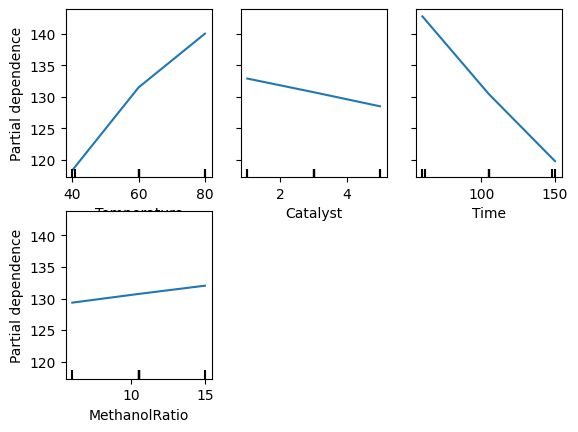

In [ ]:
features_to_plot = ['Temperature', 'Catalyst', 'Time', 'MethanolRatio']
results = PartialDependenceDisplay.from_estimator(ann_best, X_train, features_to_plot)

# Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_best_params = hyper_param_fit(model=rf, param_grid=rf_param_grid, scoring='r2', cv=3)

print(rf_best_params)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [ ]:
rf_best = RandomForestRegressor(**rf_best_params, random_state=42)
#start the timer
start_time = time.time()

rf_best.fit(X_train_scaled, y_train.values)

#calculate the execution time
execution_time_rf = time.time() - start_time
print("Execution time for RF: {:.2f} seconds".format(execution_time_rf))

y_pred = rf_best.predict(X_test_scaled)

r2 = r2_score(y_test.values, y_pred)
print("R^2 score of Random Forest:", r2)

Execution time for RF: 0.38 seconds
R^2 score of Random Forest: -0.6333105779682542


In [ ]:
model_prediction(model=rf_best, model_name='RF')

,Actual,RF Predicted
27,92.6,89.373464
16,81.8,64.570136
12,84.0,79.306299
22,70.0,77.947097
8,75.6,85.565858
9,69.6,82.225600


# XGBoost

In [ ]:
xgb = XGBRegressor(random_state=42)

In [ ]:
xgb_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}

xgb_best_params = hyper_param_fit(model=xgb, param_grid=xgb_param_grid)

print(xgb_best_params)

{'max_depth': 5, 'n_estimators': 100}


In [ ]:
xgb_best = XGBRegressor(**xgb_best_params, random_state=42)

#start the timer
start_time = time.time()

xgb_best.fit(X_train_scaled, y_train.values)

#calculate the execution time
execution_time_xgb = time.time() - start_time
print("Execution time for XGB: {:.2f} seconds".format(execution_time_xgb))

y_pred = xgb_best.predict(X_test_scaled)

r2 = r2_score(y_test.values, y_pred)
print("R^2 score of XGB:", r2)

Execution time for XGB: 0.03 seconds
R^2 score of XGB: -4.506898721489433


In [ ]:
model_prediction(model=xgb_best, model_name='XGB')

,Actual,XGB Predicted
27,92.6,93.398491
16,81.8,49.423584
12,84.0,58.405266
22,70.0,77.624275
8,75.6,88.462135
9,69.6,85.971909


In [ ]:
result = model_prediction(model=xgb_best, model_name='SVR')

print(r2_score(result['Actual'], result['SVR Predicted']),mean_squared_error(result['Actual'], result['SVR Predicted']))

-4.506898721489433 365.92730126661564


# Kernel Ridge Regression

In [ ]:
krr = KernelRidge()

krr_param_grid = {'alpha': [0.1, 0.5, 1.0], 'kernel': ['linear', 'rbf']}

krr_best_params = hyper_param_fit(model=krr, param_grid=krr_param_grid)

print(krr_best_params)

{'alpha': 0.1, 'kernel': 'rbf'}


In [ ]:
krr_best = KernelRidge(**krr_best_params)

#start the timer
start_time = time.time()

krr_best.fit(X_train_scaled, y_train.values)

#calculate the execution time
execution_time_krr = time.time() - start_time
print("Execution time for Kernel Ridge Regression: {:.2f} seconds".format(execution_time_krr))

y_pred = krr_best.predict(X_test_scaled)

r2 = r2_score(y_test.values, y_pred)
print("R^2 score of KRR:", r2)

Execution time for Kernel Ridge Regression: 0.00 seconds
R^2 score of KRR: -6.884698521271618


In [ ]:
model_prediction(model=krr_best, model_name='KRR')

,Actual,KRR Predicted
27,92.6,94.319713
16,81.8,36.694115
12,84.0,53.614089
22,70.0,76.668843
8,75.6,67.876136
9,69.6,78.468104


In [ ]:
result = model_prediction(model=krr_best, model_name='SVR')

print(r2_score(result['Actual'], result['SVR Predicted']),mean_squared_error(result['Actual'], result['SVR Predicted']))

-6.884698521271618 523.9294559623644


#Support Vector Regression

In [ ]:
svr = SVR()

svr_param_grid = {
    'kernel': ['linear','poly','rbf'],
    'C': [0.1,1,10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.01, 0.001],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.5, 1.0]}

svr_best_params = hyper_param_fit(model=svr, param_grid=svr_param_grid)

print(svr_best_params)

{'C': 1, 'coef0': 1.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}


In [ ]:
svr_best = SVR(**svr_best_params, random_state = 42)

#start the timer
start_time = time.time()

svr_best.fit(X_train_scaled, y_train.values)

#calculate the execution time
execution_time_svr = time.time() - start_time
print("Execution time for SVR: {:.2f} seconds".format(execution_time_svr))

y_pred = svr_best.predict(X_test_scaled)

r2 = r2_score(y_test.values, y_pred)
print("R^2 score of SVR:", r2)

SVR(C=3, coef0=0.5, degree=2, epsilon=0.001, kernel='poly')

In [ ]:
model_prediction(model=svr_best, model_name='SVR')

In [ ]:

result = model_prediction(model=svr_best, model_name='SVR')

print(r2_score(result['Actual'], result['SVR Predicted']),mean_squared_error(result['Actual'], result['SVR Predicted']))